<a href="https://colab.research.google.com/github/tb-harris/neuroscience-2024/blob/main/07_Linear_Regression_with_Gene_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Regression with Gene Data

## Setup

In [ ]:
import pandas as pd # pandas (DataFrames)
import seaborn as sns # graphs
import statsmodels.formula.api as smf # regression models
# installing and importing the custom diagnostics module
%pip install git+https://github.com/tb-harris/diagnostics.git
from diagnostics import LinearRegDiagnostic

  Cloning https://github.com/tb-harris/diagnostics.git to /tmp/pip-req-build-8_6mzwfa
  Running command git clone --filter=blob:none --quiet https://github.com/tb-harris/diagnostics.git /tmp/pip-req-build-8_6mzwfa
  Resolved https://github.com/tb-harris/diagnostics.git to commit 63e7ed899813d387d104118e3b35d435b398c0df
  Preparing metadata (setup.py) ... done
  Created wheel for diagnostics: filename=diagnostics-0.1-py3-none-any.whl size=4725 sha256=b870eb83d7c3ea8f2ec8db0fad255f6716a9392ae03e3405b912f1562024b1b5
  Stored in directory: /tmp/pip-ephem-wheel-cache-ymb1zezd/wheels/21/cb/88/c66692261515f980dd7feb94432c509c089d0277175742724f
Successfully built diagnostics


In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Read in our morph + genetic data
cell_data = pd.read_hdf('/content/drive/Shareddrives/Lisman Laboratory/Lisman 2024/Neuro/Data/processed data/genes_morph.hdf5.lz4')

# Gets all gene cols where the value for every cell is 0.
zero_genes = cell_data.columns[(cell_data == 0).all()]
# gene_data[zero_genes].sum().sum() # Double check these columns are 0

# Removes all of the columns in zero_genes from our dataframe
cell_data = cell_data.drop(zero_genes, axis="columns")

# Create dataframes with just the gene and morph data
gene_data = cell_data.iloc[:, :-24] # all rows, all columns from start until 24th-to-last
# Puts the last 24 cols into a morph_data dataframe
morph_data = cell_data.iloc[:, -24:] # all rows, all columns from 24-th-to-last to end

## Examining our relationship before making a linear regression

Let's take a look at the relationship between the Rbfox1 gene and total axon length.

In [ ]:
cell_data['Rbfox1'].corr(cell_data['axon.total_length'])

0.38271027699491184

Let's make a scatterplot to look at the relationship between the gene and feature:

<Axes: xlabel='Rbfox1', ylabel='axon.total_length'>

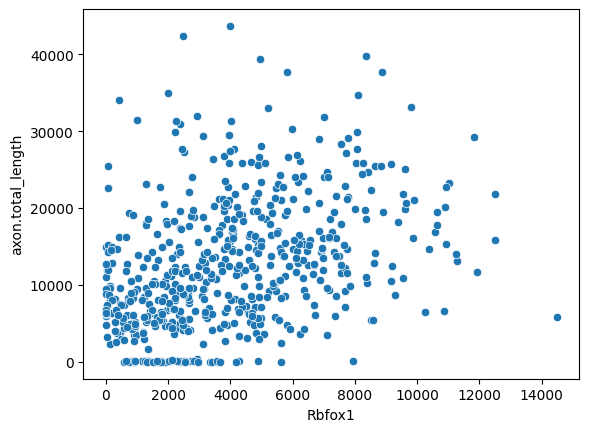

In [ ]:
sns.scatterplot(data=cell_data, x='Rbfox1', y='axon.total_length')

In [ ]:
(cell_data['Rbfox1'] == 0).sum()

5

We can see there are only 5 cells w/ no Rbfox1 expressed

In [ ]:
cell_data['axon.total_length'].describe()

count      573.000000
mean     12656.059800
std       8323.463038
min          7.123657
25%       6326.230543
50%      11639.863750
75%      17840.064090
max      43682.716180
Name: axon.total_length, dtype: float64

It looked like there were some axon lengths at 0, but we can see here that the minimum is 7 (which looks like 0 on the scatter plot)

Things look fairly linear in our scatterplot, so that's a sign that we may not need a transformation before running our linear regression (although we still need to check the diagnostic plots after running the regression!)

## Running our linear regression

When working with data columns that have .'s in the name (or other non-alphanumeric characters), we need to wrap the variable name in a Q() function inside of our formula.


**Example:** `axon.total_length` becomes `Q("axon.tota_length")`

[Patsy Formula Language](https://patsy.readthedocs.io/en/latest/formulas.html)



In [ ]:
model_rbfox1 = smf.ols(data=cell_data, formula='Q("axon.total_length") ~ Rbfox1').fit()

Let's take a look at the summary metrics for our new model!

In [ ]:
model_rbfox1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     Q("axon.total_length")   R-squared:                       0.146
Model:                                OLS   Adj. R-squared:                  0.145
Method:                     Least Squares   F-statistic:                     97.98
Date:                    Wed, 10 Jul 2024   Prob (F-statistic):           1.99e-21
Time:                            15:20:32   Log-Likelihood:                -5939.6
No. Observations:                     573   AIC:                         1.188e+04
Df Residuals:                         571   BIC:                         1.189e+04
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8015.5896    568.462     14.100      0.000    6899.058    9132.121
Rbfox1         1.1526      0.116      9.899      0.000       0.924       1.381
==============================================================================
Omnibus:                       62.998   Durbin-Watson:                   1.687
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.872
Skew:                           0.802   Prob(JB):                     1.37e-19
Kurtosis:                       4.031   Cond. No.                     8.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

* R squared: 14.6% of the variation is axon length is being explained by Rbfox1
* For every 1 ppm increase in Rbfox1 expression, we are 95% confident that the axon length increases by between 0.924 and 1.381 micrometers (if we kept collecting samples, 95% of the time our true slope would fall within that interval)

## Diagnostic Plots

Let's validate our assumptions required for making a linear regression by taking a look at our diagnostics

In [ ]:
d_rbfox1 = LinearRegDiagnostic(model_rbfox1) # create our diagnostic plotting object

<Axes: title={'center': 'Residuals vs Fitted'}, xlabel='Fitted values', ylabel='Residuals'>

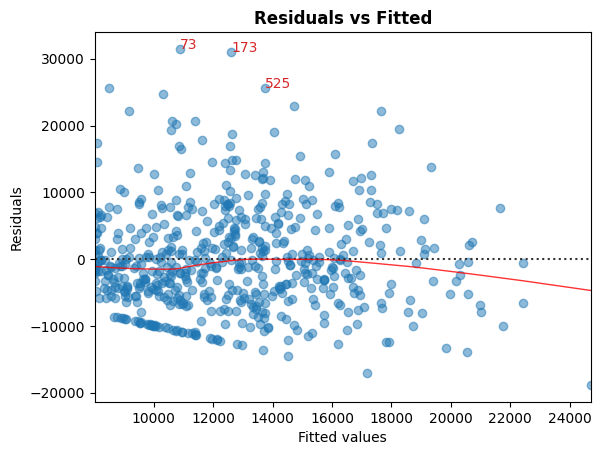

In [ ]:
d_rbfox1.residual_plot()

Our line is horizontal-ish at the beginning, but not so much at the end -- let's look at a scale-location plot to get more of a zoomed in view

<Axes: title={'center': 'Scale-Location'}, xlabel='Fitted values', ylabel='$\\sqrt{|\\mathrm{Standardized\\ Residuals}|}$'>

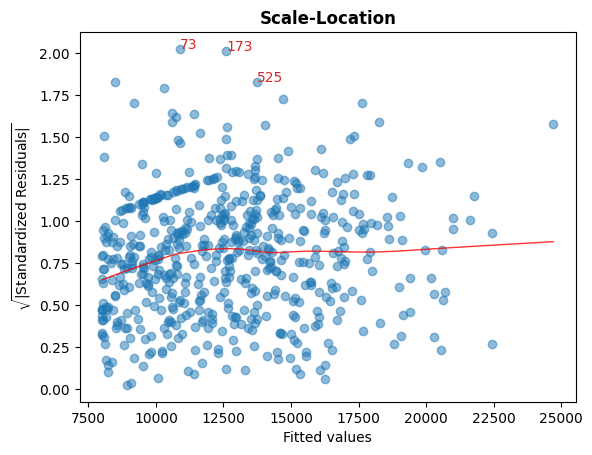

In [ ]:
d_rbfox1.scale_location_plot()

Looks pretty horizontal! So far the relationship between our independent and dependent variables is looking linear, and we have a fairly equal standard deviation of residuals

<Axes: title={'center': 'Residuals vs Leverage'}, xlabel='Leverage', ylabel='Standardized Residuals'>

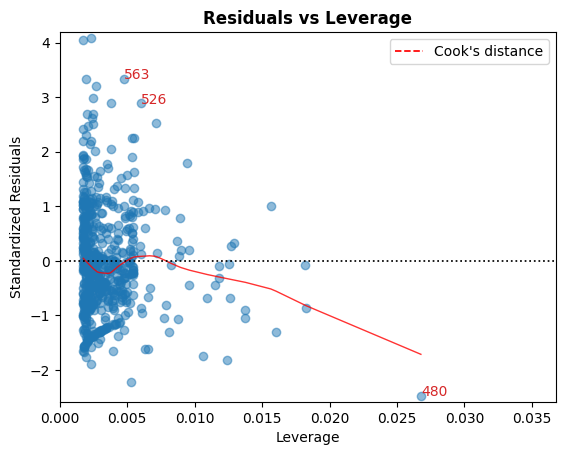

In [ ]:
d_rbfox1.leverage_plot()

This one looks alright -- no cook's distance lines.

<Axes: title={'center': 'Normal Q-Q'}, xlabel='Theoretical Quantiles', ylabel='Standardized Residuals'>

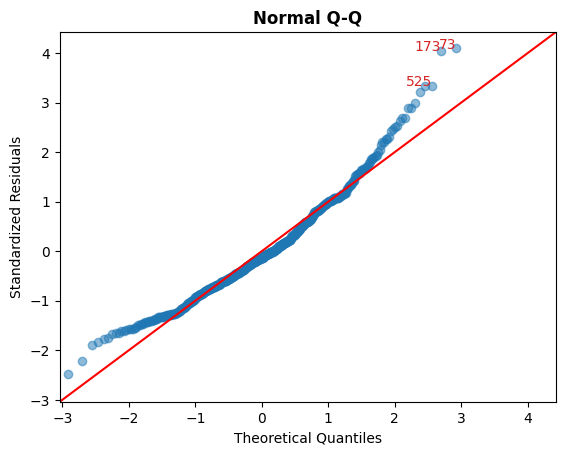

In [ ]:
d_rbfox1.qq_plot()

**Problem!** We have too many residuals that are more positive than we'd expect from a normal distribution, too few negatives. Let's take another look at the scatter plot, this time with our regression line

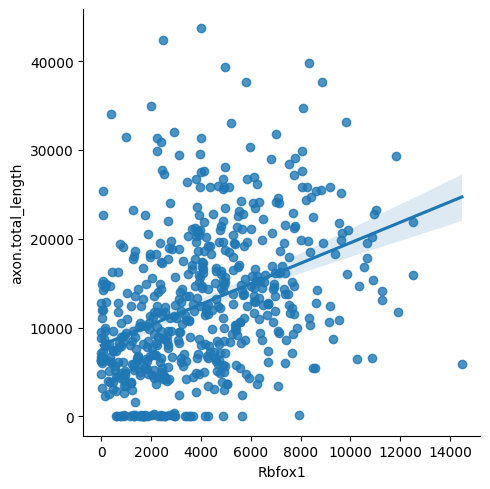

In [ ]:
sns.lmplot(data=cell_data, x='Rbfox1', y='axon.total_length')

We can see from the scatterplot as well that this line doesn't describe the more extreme axon lengths --> We might want to try a transformation

If we violate the assumptions, we can't say that our p value is correct

## Transforming our data
Two options:
* We have extreme y values, so we could take log(y), or
* We could try x^2 (parabolic shape can capture higher y values)

### Log Transformation
We can add new columns to our cell_data dataframe with the transformed data:

In [ ]:
import numpy as np # Imports some functions we can use on our dataframe columns

In [ ]:
# Add a new column to the dataset with the natural log of our axon length
# We checked before that there are no 0s, so this is safe to do (we cannot take a log of 0)
cell_data['log_axon.total_length'] = np.log(cell_data['axon.total_length'])

In [ ]:
model_rbfox1_log = smf.ols(data=cell_data, formula='Q("log_axon.total_length") ~ Rbfox1').fit()

In [ ]:
model_rbfox1_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                                
======================================================================================
Dep. Variable:     Q("log_axon.total_length")   R-squared:                       0.088
Model:                                    OLS   Adj. R-squared:                  0.086
Method:                         Least Squares   F-statistic:                     55.05
Date:                        Wed, 10 Jul 2024   Prob (F-statistic):           4.28e-13
Time:                                15:57:04   Log-Likelihood:                -1045.4
No. Observations:                         573   AIC:                             2095.
Df Residuals:                             571   BIC:                             2104.
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.2579      0.111     74.399      0.000       8.040       8.476
Rbfox1         0.0002   2.27e-05      7.420      0.000       0.000       0.000
==============================================================================
Omnibus:                      303.524   Durbin-Watson:                   1.354
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1456.167
Skew:                          -2.473   Prob(JB):                         0.00
Kurtosis:                       9.044   Cond. No.                     8.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

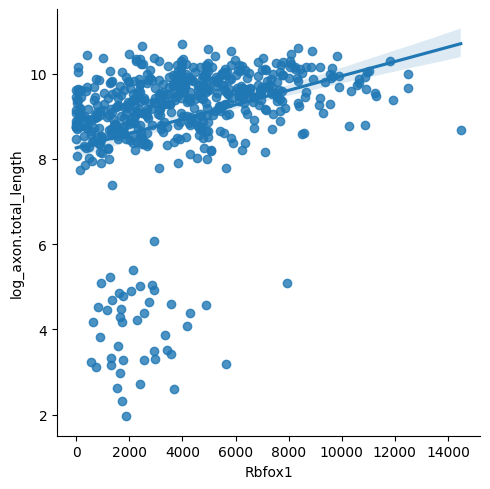

In [ ]:
sns.lmplot(data=cell_data, x='Rbfox1', y='log_axon.total_length')

<Axes: title={'center': 'Normal Q-Q'}, xlabel='Theoretical Quantiles', ylabel='Standardized Residuals'>

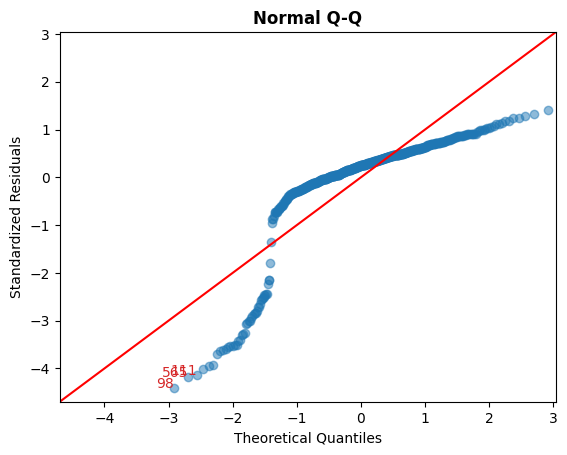

In [ ]:
d_log = LinearRegDiagnostic(model_rbfox1_log)
d_log.qq_plot()

Log transformation is not looking great.

### Squared term

In [ ]:
# Create a new column called sq_Rbfox1 with the squared data
cell_data['sq_Rbfox1'] = cell_data['Rbfox1']**2

In [ ]:
model_rbfox1_sq = smf.ols(data=cell_data, formula='Q("axon.total_length") ~ sq_Rbfox1 + Rbfox1').fit()

In [ ]:
model_rbfox1_sq.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     Q("axon.total_length")   R-squared:                       0.156
Model:                                OLS   Adj. R-squared:                  0.153
Method:                     Least Squares   F-statistic:                     52.67
Date:                    Wed, 10 Jul 2024   Prob (F-statistic):           1.03e-21
Time:                            16:09:22   Log-Likelihood:                -5936.3
No. Observations:                     573   AIC:                         1.188e+04
Df Residuals:                         570   BIC:                         1.189e+04
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6683.3435    772.407      8.653      0.000    5166.232    8200.455
sq_Rbfox1  -8.376e-05   3.31e-05     -2.534      0.012      -0.000   -1.88e-05
Rbfox1         1.9794      0.346      5.716      0.000       1.299       2.660
==============================================================================
Omnibus:                       61.539   Durbin-Watson:                   1.690
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               84.273
Skew:                           0.791   Prob(JB):                     5.02e-19
Kurtosis:                       4.014   Cond. No.                     9.05e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.05e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
print(model_rbfox1.aic, model_rbfox1_sq.aic)
print(model_rbfox1.bic, model_rbfox1_sq.bic)

11883.107350456125 11878.690570284216
11891.809121889553 11891.743227434361


AIC and BIC seem very very marginally better. Overall, based on the adjusted R^2, AIC, BIC, we have a little improvement but not substantial

R^2 is statsitically significant

<Axes: title={'center': 'Normal Q-Q'}, xlabel='Theoretical Quantiles', ylabel='Standardized Residuals'>

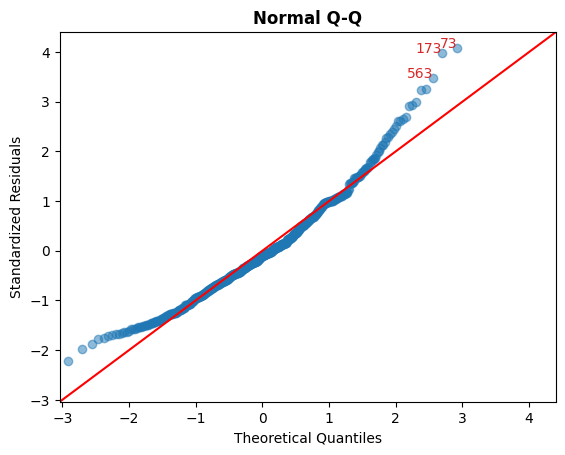

In [ ]:
d_sq = LinearRegDiagnostic(model_rbfox1_sq)
d_sq.qq_plot()

### Box-cox

The Box-Cox transformation picks an optimal value of $\lambda$ such that $\frac{y^\lambda-1}{\lambda}$

**Example**
<img src="https://media.geeksforgeeks.org/wp-content/uploads/20200531232546/output275.png">

<Axes: xlabel='axon.total_length', ylabel='Count'>

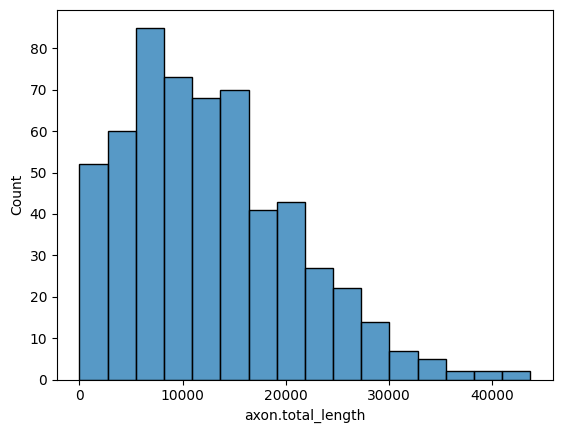

In [ ]:
sns.histplot(cell_data['axon.total_length'])

Our distribution of *axon.total_length* is not very normal, so that's an indicator that Box-Cox could be helpful.

In [ ]:
from scipy import stats

# Performing the box cox transformation on our axon.total_length and getting transformed
#  data and optimal lambda value
transformed_data, lam = stats.boxcox(cell_data['axon.total_length'])

# Save the transformed data into our dataframe
cell_data['box_axon.total_length'] = transformed_data

In [ ]:
print(lam)

0.574309101133504


<Axes: xlabel='axon.total_length', ylabel='Count'>

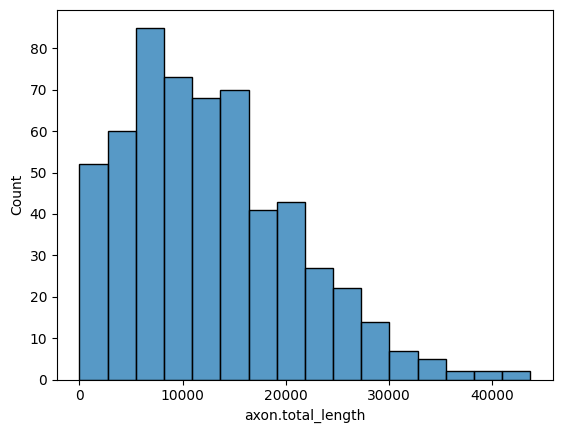

In [ ]:
sns.histplot(cell_data['axon.total_length'])

<Axes: xlabel='box_axon.total_length', ylabel='Count'>

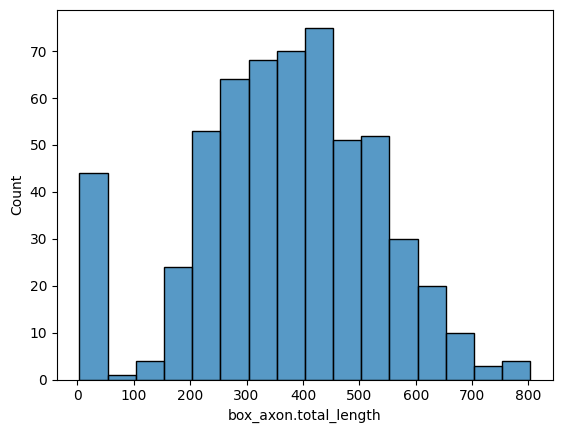

In [ ]:

sns.histplot(cell_data['box_axon.total_length'])

We can see that our optimal $\lambda = 0.57$, which means we will be approximately square rooting our axon length value. That could be an indicator that square rooting our data might make sense.

Note: If we saw 0.3, for example, that could be a sign to try cube root. If we see a really small lambda (less than ~0.25), maybe try log. Lambda 2 might suggest squaring.

### Square Root

In [ ]:
cell_data['sqrt_axon.total_length'] = np.sqrt(cell_data['axon.total_length'])

<Axes: xlabel='sqrt_axon.total_length', ylabel='Count'>

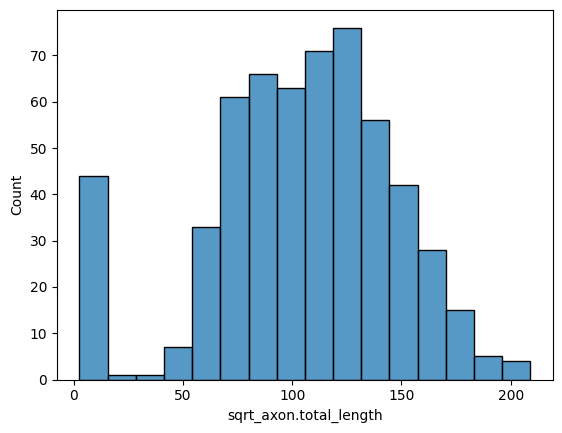

In [ ]:
sns.histplot(cell_data['sqrt_axon.total_length'])

In [ ]:
model_rbfox1_sqrt = smf.ols(data=cell_data, formula='Q("sqrt_axon.total_length") ~ Rbfox1').fit()

<Axes: title={'center': 'Normal Q-Q'}, xlabel='Theoretical Quantiles', ylabel='Standardized Residuals'>

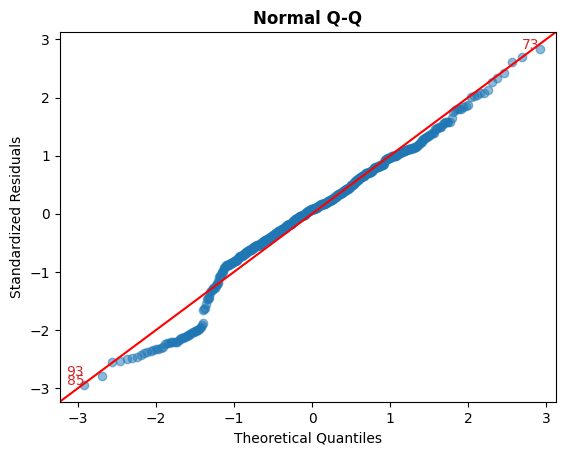

In [ ]:
d_sqrt = LinearRegDiagnostic(model_rbfox1_sqrt)
d_sqrt.qq_plot()

This might be about as good as we can get with a single-variable regression!

A good next step would be going back to look at all the other diagnostic plots, and also our summary.

In [ ]:
model_rbfox1_sqrt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     Q("sqrt_axon.total_length")   R-squared:                       0.148
Model:                                     OLS   Adj. R-squared:                  0.146
Method:                          Least Squares   F-statistic:                     98.91
Date:                         Wed, 10 Jul 2024   Prob (F-statistic):           1.34e-21
Time:                                 17:32:26   Log-Likelihood:                -2911.3
No. Observations:                          573   AIC:                             5827.
Df Residuals:                              571   BIC:                             5835.
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     80.6693      2.881     28.003      0.000      75.011      86.327
Rbfox1         0.0059      0.001      9.945      0.000       0.005       0.007
==============================================================================
Omnibus:                       19.568   Durbin-Watson:                   1.545
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.015
Skew:                          -0.421   Prob(JB):                     2.73e-05
Kurtosis:                       3.412   Cond. No.                     8.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

* We can't directly compare the adjusted R^2 to that of our original model because we are working with different scales
* For every 1 ppm increase in Rbfox1, the sqrt of the total axon length increases by 0.0059 sqrt(micrometers)

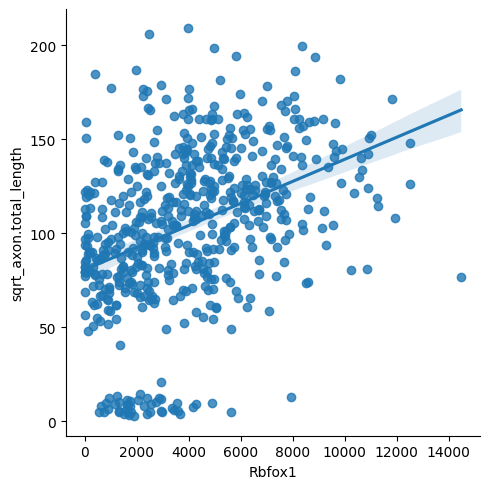

In [ ]:
sns.lmplot(data=cell_data, x='Rbfox1', y='sqrt_axon.total_length')

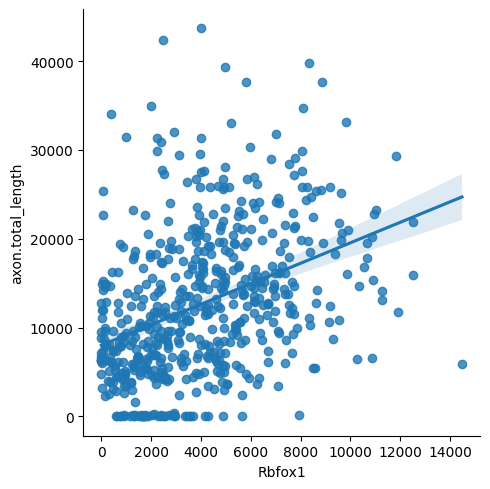

In [ ]:
sns.lmplot(data=cell_data, x='Rbfox1', y='axon.total_length')

## Multiple regression

Let's take a look at all 5 genes we had previously examined with axon length:

```
Rbfox1
Coro6
Fmn1
Nxph1
Etl4
```


### Correlation Matrix

In [ ]:
target_genes = ['Rbfox1', 'Coro6', 'Fmn1', 'Nxph1', 'Etl4']

In [ ]:
# Create a dataframe with just the expression of the target genes
target_gene_exp = cell_data[target_genes]
target_gene_exp

In [ ]:
target_gene_exp.corr()

,Rbfox1,Coro6,Fmn1,Nxph1,Etl4
Rbfox1,1.000000,0.404952,0.393733,0.488823,0.556622
Coro6,0.404952,1.000000,0.386890,0.275662,0.231469
Fmn1,0.393733,0.386890,1.000000,0.273713,0.325916
Nxph1,0.488823,0.275662,0.273713,1.000000,0.395103
Etl4,0.556622,0.231469,0.325916,0.395103,1.000000


Etl4 and Rbfox1 could be so correlated that they could make it more difficult to find statistical significance / ascribe separate effects to each one.

### Creating our 5-variable model

In [ ]:
model_5_gene = smf.ols(
    data=cell_data,
    formula='Q("axon.total_length") ~ Rbfox1 + Coro6 + Fmn1 + Nxph1 + Etl4'
).fit()

In [ ]:
model_5_gene.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     Q("axon.total_length")   R-squared:                       0.271
Model:                                OLS   Adj. R-squared:                  0.264
Method:                     Least Squares   F-statistic:                     42.10
Date:                    Wed, 10 Jul 2024   Prob (F-statistic):           6.86e-37
Time:                            17:51:44   Log-Likelihood:                -5894.5
No. Observations:                     573   AIC:                         1.180e+04
Df Residuals:                         567   BIC:                         1.183e+04
Df Model:                               5                                         
Covariance Type:                nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6676.8552    550.031     12.139      0.000    5596.508    7757.203
Rbfox1         0.2551      0.147      1.736      0.083      -0.034       0.544
Coro6         18.6801      3.822      4.887      0.000      11.173      26.188
Fmn1           9.2298      2.237      4.127      0.000       4.837      13.623
Nxph1          1.3342      0.336      3.965      0.000       0.673       1.995
Etl4           0.8382      0.299      2.808      0.005       0.252       1.425
==============================================================================
Omnibus:                       85.212   Durbin-Watson:                   1.771
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              146.398
Skew:                           0.909   Prob(JB):                     1.62e-32
Kurtosis:                       4.681   Cond. No.                     9.71e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.71e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Adj R^2 has improved, AIC and BIC a little better but very marginal.

**Next step**: Running all of the possible combinations of variables and seeing which results in the best model